# Predicting Employee Attrition


## 1. Business problem and summary statement

The goal of this project is to **predict employee attrition** within our organization.<br>
We want to **identify key factors contributing to employee turnover** and build a predictive model that can help
us understand and mitigate attrition by using a dataset from Kaggle.<br>
Employee attrition has a significant impact on an organization's **productivity and costs**. Reducing
attrition can lead to cost savings and improve overall employee morale. This project aims to
provide actionable insights and strategies for retaining valuable talent.<br>
This project is applicable to any industry or organization that employs personnel. It's particularly
relevant for companies that want to **enhance their human resource management strategies**.
Our target audience includes HR professionals, management, and executives looking to address
employee attrition and make data-driven decisions.
If successful, this project will help organizations identify employees at risk of leaving, allowing
for early intervention and the development of targeted retention strategies. This can lead to cost
savings and improved workforce stability

The dataset contains around 1400 employees and is **unbalanced** (16% leaving and 84% staying).<br>
In the Exploratory Data Analysis I performed the following checks:
- check for missing data, outliers and duplicates
- one hot encoding for categorical data
- check for class imbalance
- bivariate analysis
- correlation analysis <br>

I then started with a vanilla logistic regression model and iterated through different classifier. My final model is a **random forest classifier** with reduced threshold to prioritize recall and tuned hyperparameters using GridSearchCV. It has a weighted average **recall of .71**. The most important features for attrition are overtime, stock options, income, job satisfaction and work-life balance.

Author: Julia Müller <br>
Date: 14.11.2023 <br>
Contact: [LinkedIn](https://www.linkedin.com/in/julia-m%C3%BCller-47363062/) 

## 2. Data Collection & Understanding


For reproducibility, here is the code to access the Kaggle dataset. This code will set up the kaggle Api and download the dataset in a subfolder of your current folder called "data". You can change this if required. 
For this code to work, you need to pip install Kaggle and input your kaggle username and api_key. Instructions how you can find these information are __[here](https://www.kaggle.com/docs/api)__ <br>
Never upload your user name and/or the api key to github or share it anywhere else.

In [1]:
import os
import json
import getpass

# Define the path to the .kaggle directory
kaggle_directory = '/root/.kaggle'

# Check if the directory already exists
if not os.path.exists(kaggle_directory):
    # If it doesn't exist, create it
    os.makedirs(kaggle_directory)
else:
    print(f"Directory {kaggle_directory} already exists, skipping creation.")

# Define your API token
api_token = {"username": "your_kaggle_username", "key": "your_kaggle_api_key"}

# Write the API token to the kaggle.json file
with open(os.path.join(kaggle_directory, 'kaggle.json'), 'w') as file:
    json.dump(api_token, file)

# Set appropriate permissions for the kaggle.json file
os.chmod(os.path.join(kaggle_directory, 'kaggle.json'), 0o600)

# Prompt the user for their Kaggle credentials without displaying the input
kaggle_username = getpass.getpass("Enter your Kaggle username: ")
kaggle_api_key = getpass.getpass("Enter your Kaggle API key: ")

#import kaggle api
from kaggle.api.kaggle_api_extended import KaggleApi

# Set up the Kaggle API
api = KaggleApi()

# Set the Kaggle environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_username
os.environ['KAGGLE_KEY'] = kaggle_api_key

# Authenticate with the Kaggle API
api.authenticate()

# Define the dataset and where to save it
dataset_name = 'pavansubhasht/ibm-hr-analytics-attrition-dataset'
save_path = './data/'

# Check if the dataset is already downloaded
if not os.path.exists(save_path):
    os.makedirs(save_path)

if not os.path.exists(os.path.join(save_path, 'attrition.csv')):
    # Download the dataset
    api.dataset_download_files(dataset_name, path=save_path, unzip=True)
else:
    print("Dataset already exists.")

# Now you can use the dataset from the specified location

Enter your Kaggle username: ········
Enter your Kaggle API key: ········


Next, I will load the remaining required packages and then load and familiarize myself with the data. 

In [2]:
#importing packages
#for data manipulation
import pandas as pd
import numpy as np
#for visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#for preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
#for modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, confusion_matrix
import xgboost as xgb
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
#reading data
df = pd.read_csv("data/WA_Fn-UseC_-HR-Employee-Attrition.csv")

In [4]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [6]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


#### Data description
I have overall 1470 employee records and 35 columns with employee data. There seem to be no missing values but I still have to check for duplicates. The data includes information about:
- the employee's demographics such as age, home address, gender or marital status
- information about the current position (department, job level or role)
- satisfaction scores (with leader, job or team)
- information about the relationship between the employee and company (tenure, promotions, salary, overtime)
- binary field if the employee left or not (attrition)

The workforce has an average age of 36 years and an average tenure with the company of 7 years. They seem to be rather satisfied with their work-life balance and overall satisfaction (average of 2.7 on a scale of 1-4). 

#### Available data
| No | Attribute Name | Meaning |
| --- | --- | --- |
| 1 | Age | Employee's age |
| 2 | Gender | Employee's Gender |
| 3 | BusinessTravel | Frequency of employees' business trips |
| 4 | DailyRate | Daily salary rate for employees |
| 5 | Department | Office of employees |
| 6 | DistanceFromHome | Distance from home in miles to work |
| 7 | Education | Level of education achieved by staff |
| 8 | EducationField | Employee's field of study |
| 9 | EmployeeCount | Total number of employees in the organization |
| 10 | EmployeeNumber | A unique identifier for each employee record |
| 11 | EnvironmentSatisfaction | Employee satisfaction with their working environment |
| 12 | HourlyRate | Hourly rate for employees |
| 13 | JobInvolvement | Level of involvement required for the employee's job |
| 14 | JobLevel | Employee's level of work |
| 15 | JobRole | The role of employees in the organization |
| 16 | JobSatisfaction | Employee satisfaction with their work |
| 17 | MaritalStatus | Employee's marital status |
| 18 | MonthlyIncome | Employee's monthly income |
| 19 | MonthlyRate | Monthly salary rate for employees |
| 20 | NumCompaniesWorked | Number of companies the employee worked for |
| 21 | Over18 | Whether the employee is over 18 years old |
| 22 | OverTime | Do employees work overtime |
| 23 | PercentSalaryHike | Salary increase rate for employees |
| 24 | PerformanceRating | The performance rating of the employee |
| 25 | RelationshipSatisfaction | Employee satisfaction with their relationships |
| 26 | StandardHours | Standard working hours for employees |
| 27 | StockOptionLevel | Employee stock option level |
| 28 | TotalWorkingYears | Total number of years the employee has worked |
| 29 | TrainingTimesLastYear | Number of times employees were taken to training in the last year |
| 30 | WorkLifeBalance | Employees' perception of their work-life balance |
| 31 | YearsAtCompany | Number of years employees have been with the company |
| 32 | YearsInCurrentRole | Number of years the employee has been in their current role |
| 33 | YearsSinceLastPromotion | Number of years since the employee's last promotion |
| 34 | YearsWithCurrManager | Number of years an employee has been with their current manager |
| 35 | Attrition | Does the employee leave the organization |

#### Meaning of categories
Education: 1 'Below College' 2 'College' 3 'Bachelor' 4 'Master' 5 'Doctor'

EnvironmentSatisfaction: 1 'Low' 2 'Medium' 3 'High' 4 'Very High'

JobInvolvement 1 'Low' 2 'Medium' 3 'High' 4 'Very High'

JobSatisfaction: 1 'Low' 2 'Medium' 3 'High' 4 'Very High'

PerformanceRating: 1 'Low' 2 'Good' 3 'Excellent' 4 'Outstanding'

RelationshipSatisfaction: 1 'Low' 2 'Medium' 3 'High' 4 'Very High'

WorkLifeBalance: 1 'Bad' 2 'Good' 3 'Better' 4 'Best'

## 3. Exploratory Data Analysis

In this section, I will:
- examing the dataset for missing values and outliers
- handle missing values (if any)
- encode categorical variables
- check for imbalances in the target variable (attrition)

### 3.1: Missing values, duplicates and outliers

In [7]:
# Step 1: Checking for Missing Values
# Check for missing values in each column
missing_values = df.isnull().sum()
missing_values
# Step 2: Checking for Duplicates
# Check for duplicate rows in the dataset
duplicates = df[df.duplicated()]
# Display duplicate rows (if any)
if not duplicates.empty:
    print("\nDuplicate Rows:")
    print(duplicates)
else:
    print("\nNo duplicate rows found.")
#check for outliers
# Select only the numeric columns
numeric_columns = df.select_dtypes(include=[np.number])

# Calculate the first quartile (Q1) and third quartile (Q3)
Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define a threshold to identify potential outliers
threshold = 1.5

# Identify potential outliers
potential_outliers = ((numeric_columns < (Q1 - threshold * IQR)) | (numeric_columns > (Q3 + threshold * IQR)))

# Count the number of potential outliers in each numeric column
outlier_counts = potential_outliers.sum()

# Display columns with potential outliers and their counts
print("Columns with potential outliers:")
print(outlier_counts[outlier_counts > 0])


No duplicate rows found.
Columns with potential outliers:
MonthlyIncome              114
NumCompaniesWorked          52
PerformanceRating          226
StockOptionLevel            85
TotalWorkingYears           63
TrainingTimesLastYear      238
YearsAtCompany             104
YearsInCurrentRole          21
YearsSinceLastPromotion    107
YearsWithCurrManager        14
dtype: int64


In [8]:
outliercols = outlier_counts[outlier_counts > 0]
outlier_column_names = list(outliercols.index)

# Now, 'outlier_column_names' is a list of the column names
print(outlier_column_names)

['MonthlyIncome', 'NumCompaniesWorked', 'PerformanceRating', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


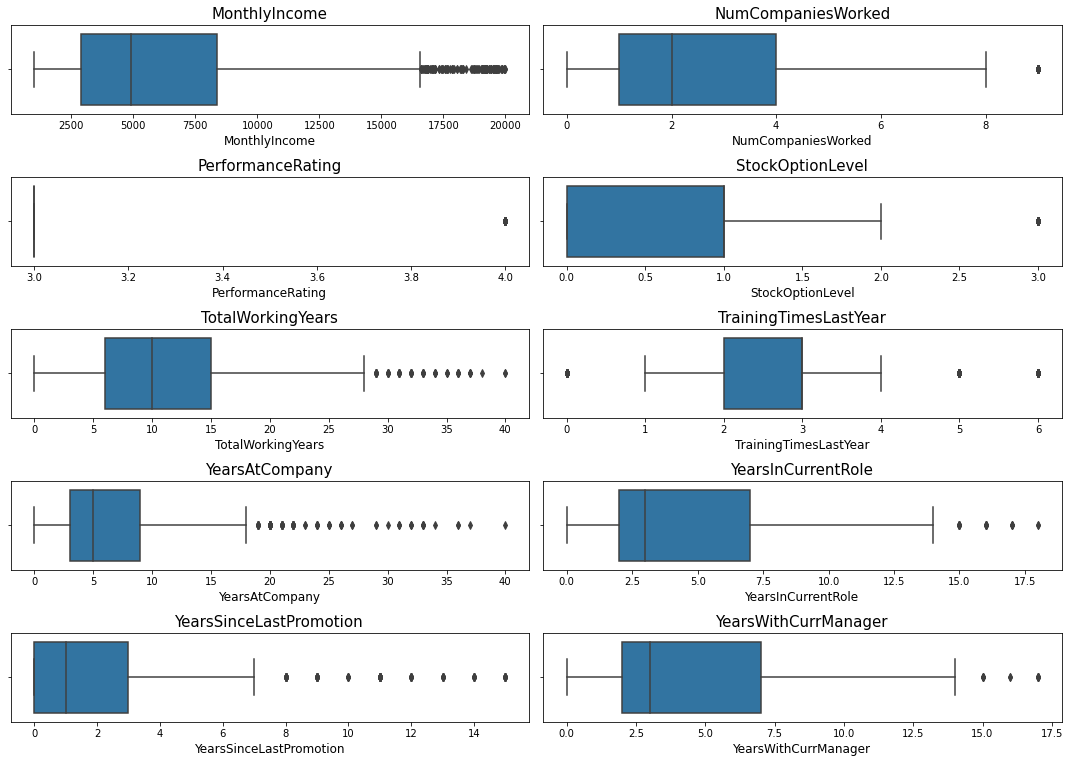

In [9]:
#show boxplots for outlier
plt.figure(figsize = (15,25))
for idx, i in enumerate(outlier_column_names):
    plt.subplot(12, 2, idx + 1)
    sns.boxplot(x = i, data = df)
    plt.title(i,fontsize=15)
    plt.xlabel(i, size = 12)
plt.tight_layout()                     
plt.show()

### Interpretation
I have no missing values, no duplicates but I do have some columns where I have outliers. However, the outliers don't seem to be data quality issues but it makes sense that there are outliers regarding salary, years in the current role or total working years. I will leave the outliers in for now and decide later what to do with them depending on how sensitive my model would be for outliers.

### 3.2: Visual data inspection
Next, besides to look at the outliers, I want to get a better feeling about my data, and the distribution of it. For this, I am looking at histograms for the numerical and non-numerical columns.

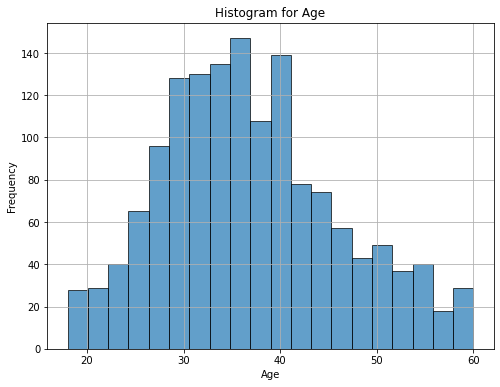

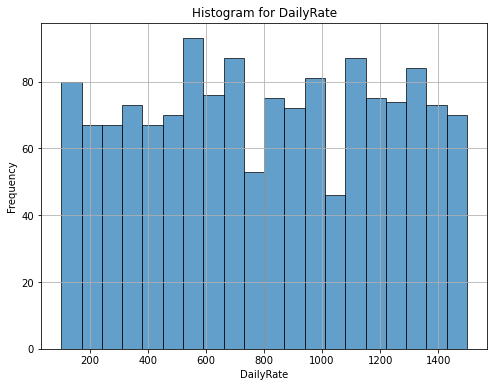

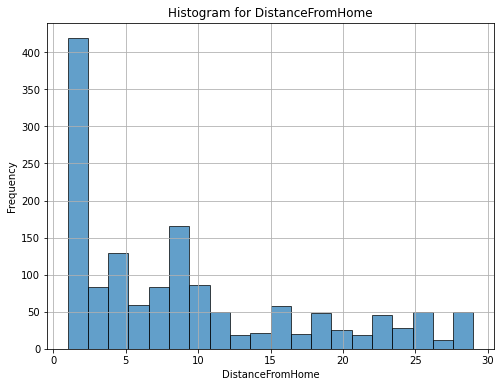

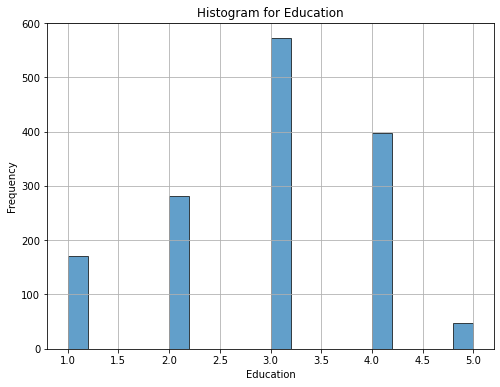

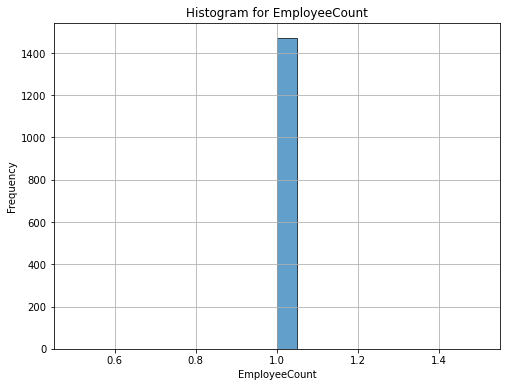

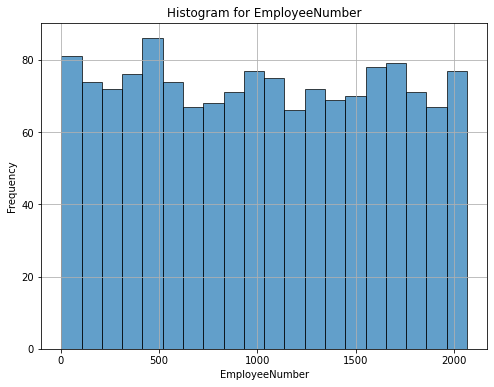

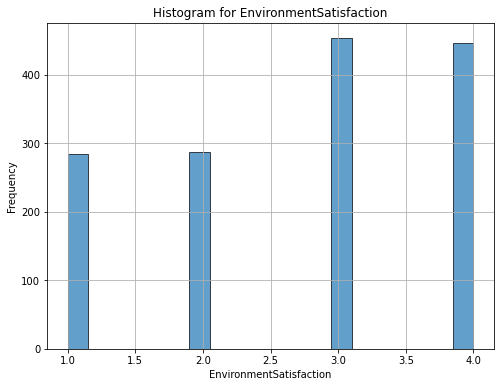

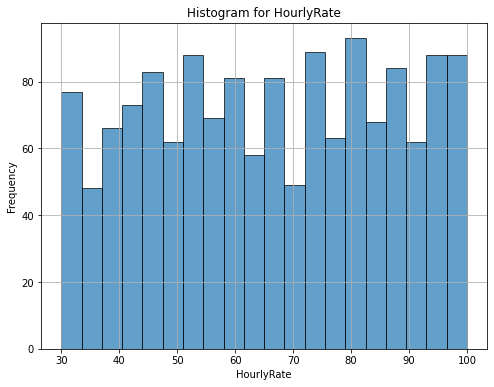

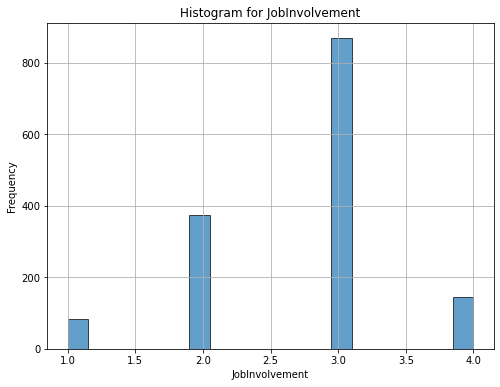

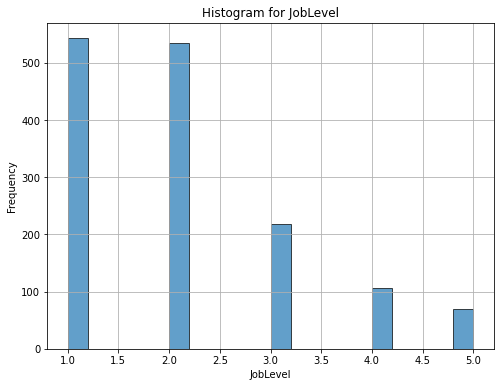

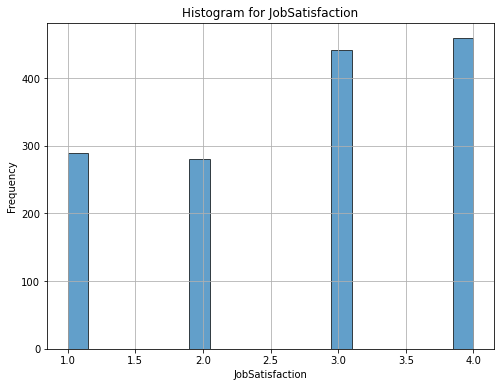

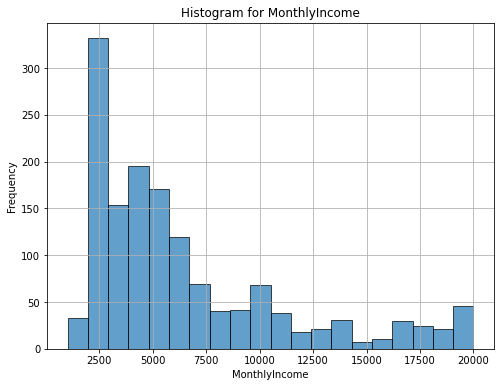

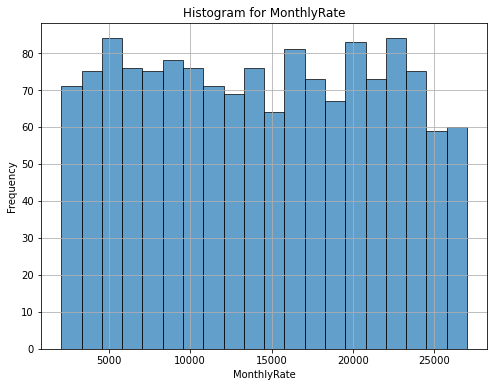

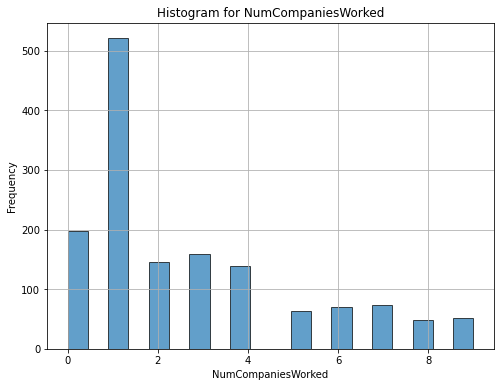

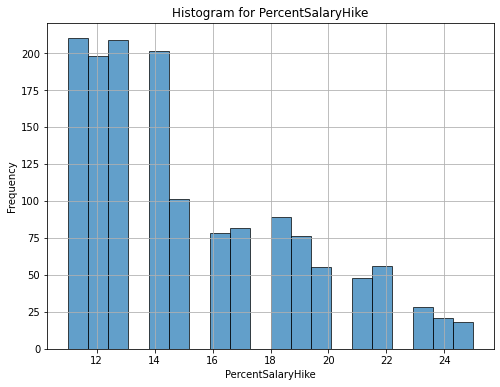

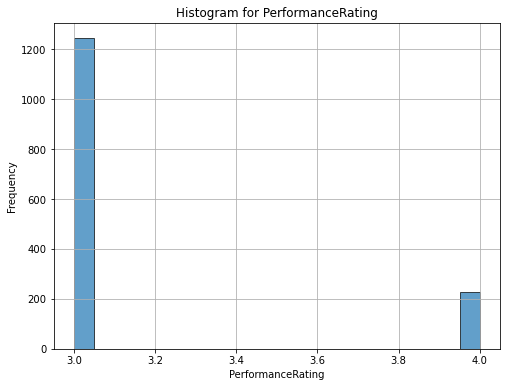

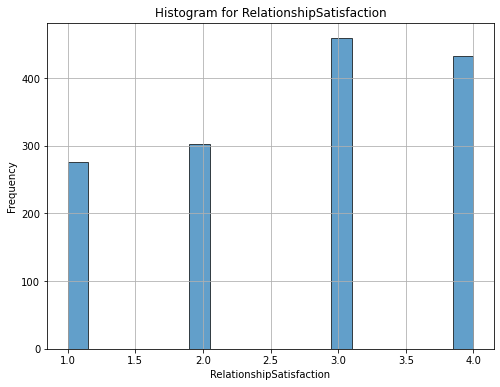

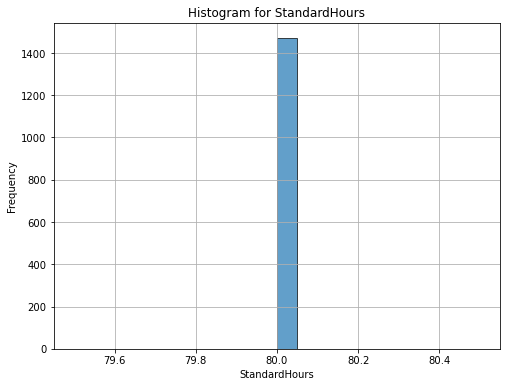

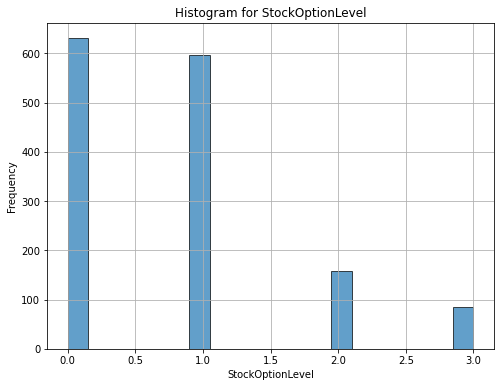

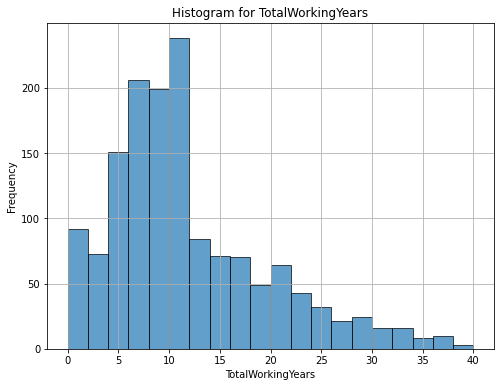

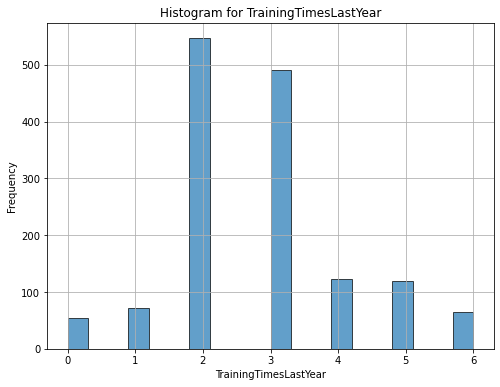

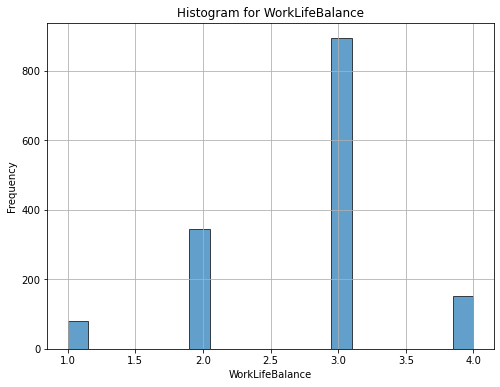

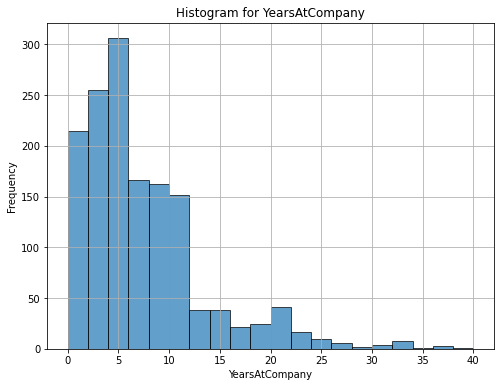

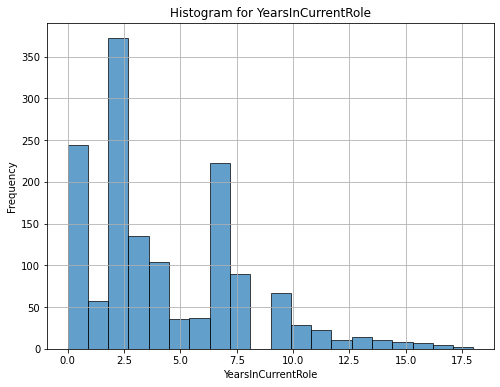

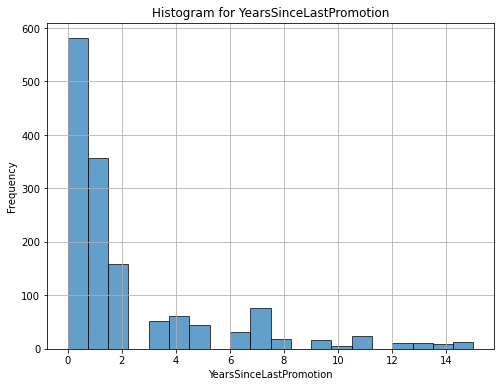

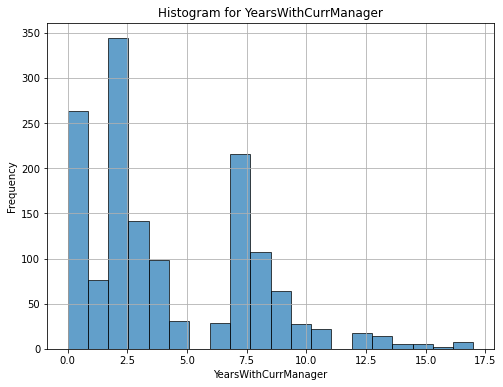

In [10]:
#visualise by using a histogram for each column
for column in numeric_columns:
    plt.figure(figsize=(8, 6))
    plt.hist(df[column], bins=20, edgecolor='k', alpha=0.7)
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

The data in the numeric columns looks pretty good. I can drop the following columns because they don't give me any value:
- Employee Count (only 1s)
- Employee Number (don't need the unique identifier anymore)
- StandardHours (everyone seems to have the same hours)

In [11]:
#dropping 3 columns
df = df.drop(["StandardHours","EmployeeCount","EmployeeNumber"], axis=1)

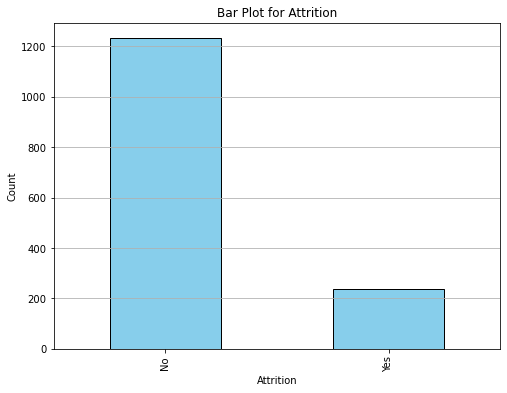

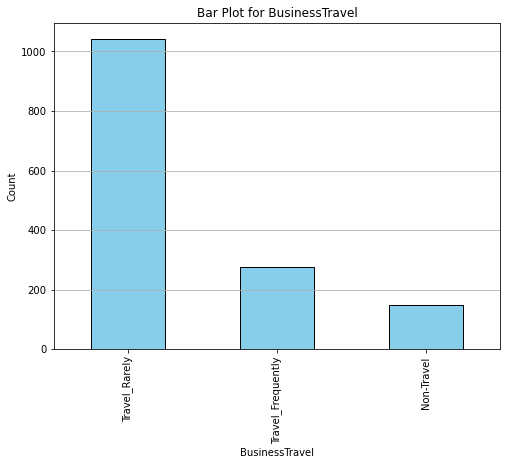

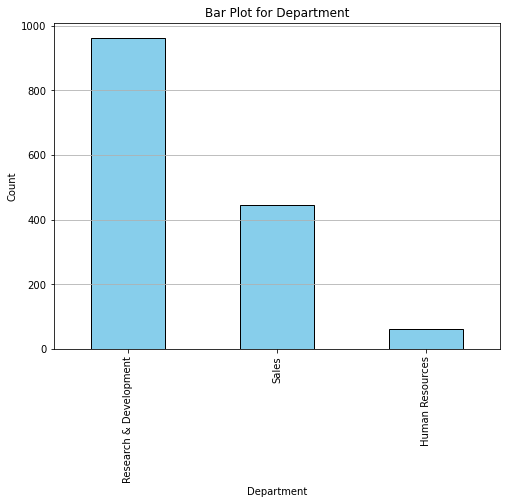

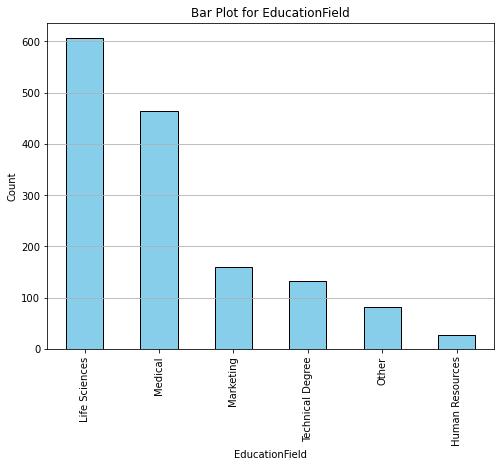

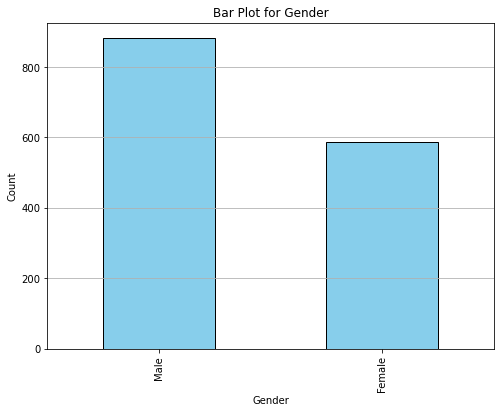

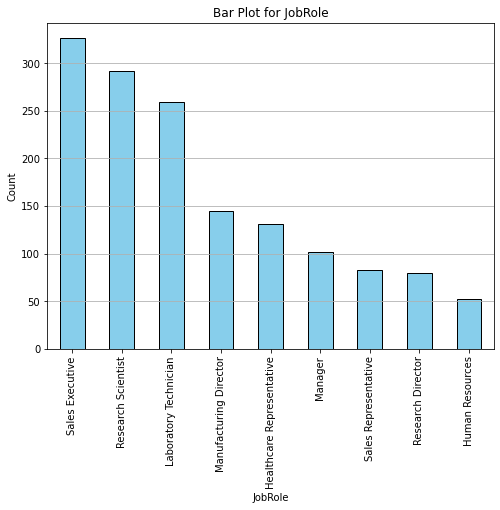

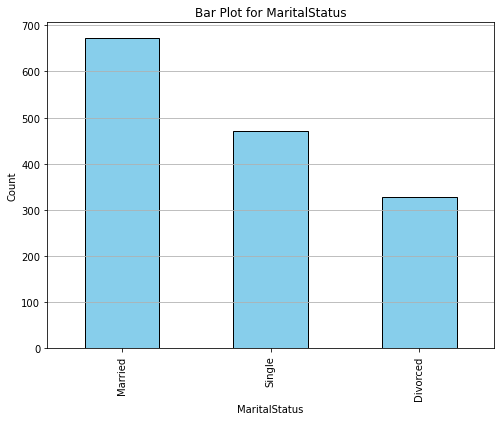

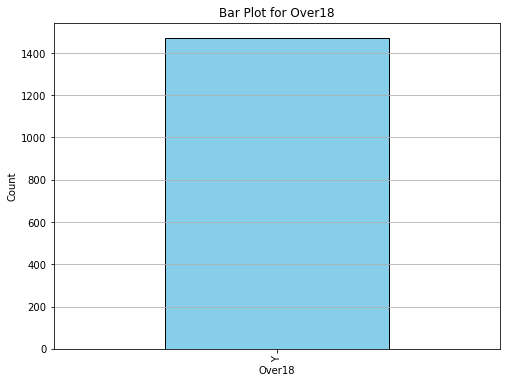

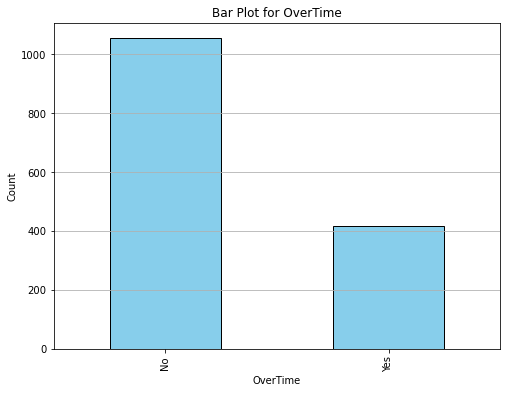

In [12]:
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns

for column in non_numeric_columns:
    plt.figure(figsize=(8, 6))
    df[column].value_counts().plot(kind='bar', color='skyblue', edgecolor='k')
    plt.title(f'Bar Plot for {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.grid(axis='y')
    plt.show()

I can drop the over 18 column as well. I can see that I have class imbalance in my target variable. I will look at it closer later.

In [13]:
#dropping over 18
df = df.drop(["Over18"], axis=1)

### 3.3: One hot encoding
I'm transforming my categorical variables to binary variables so that I can feed them into my model.

In [14]:
#data preparation for binary categorical variables
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
df['Attrition']=label_encoder.fit_transform(df['Attrition'])
df['OverTime']=label_encoder.fit_transform(df['OverTime'])
df['Gender']=label_encoder.fit_transform(df['Gender'])

#pandas one hot encoding for the rest of categorical variables


df=pd.get_dummies(df, columns=['BusinessTravel', 'Department',
                               'EducationField', 
                               'JobRole', 'MaritalStatus'])

### 3.4: Check for class imbalance

In [15]:
# Checking for class imbalance in target variable 

print("Raw Counts") 

print(df["Attrition"].value_counts()) 

print() 

print("Percentages") 

print(df["Attrition"].value_counts(normalize=True)) 

Raw Counts
0    1233
1     237
Name: Attrition, dtype: int64

Percentages
0    0.838776
1    0.161224
Name: Attrition, dtype: float64


My dataset has a strong class imbalance. Only 16% of the employees are leaving. I will have to address this by over or undersampling after splitting the data in training and test data.

### 3.5: Bivariate analysis
Next, I'm exploring the relationship between my target variable and other features.
I'm starting with the numerical features by showing box plots. 

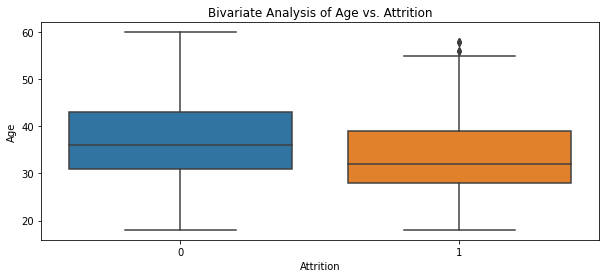

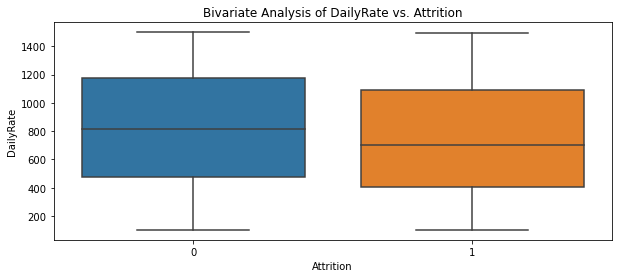

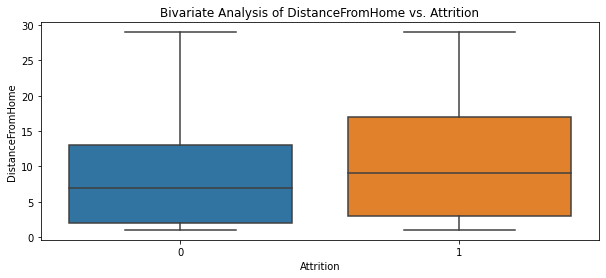

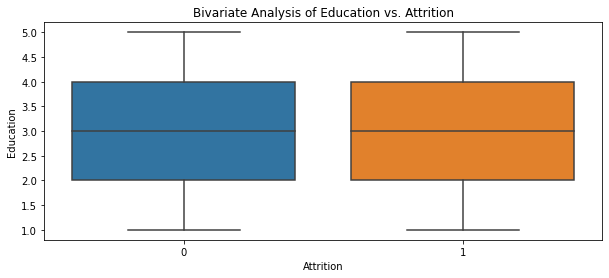

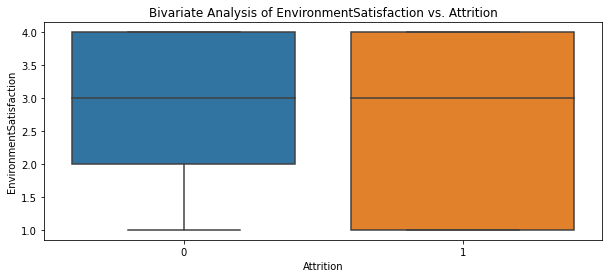

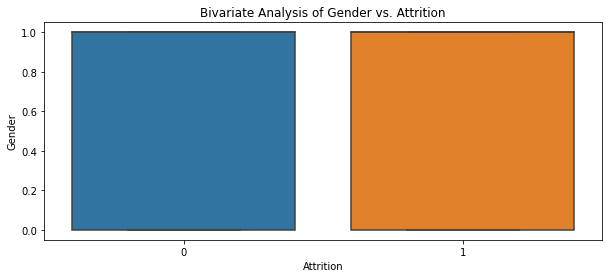

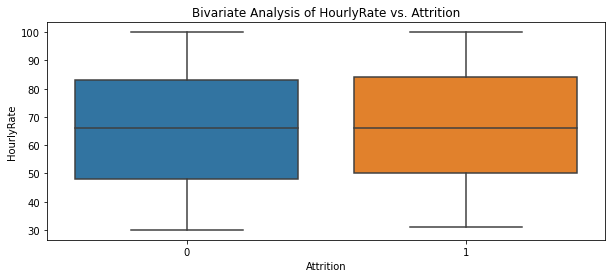

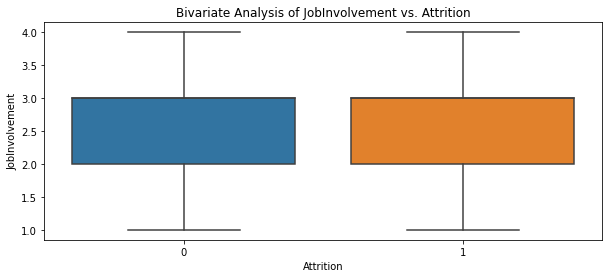

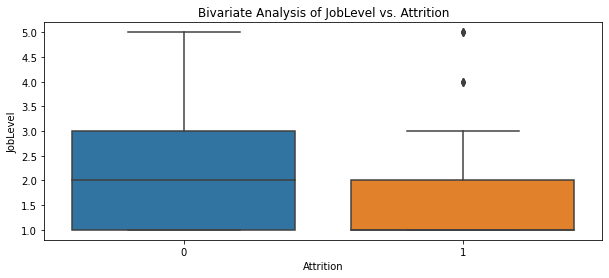

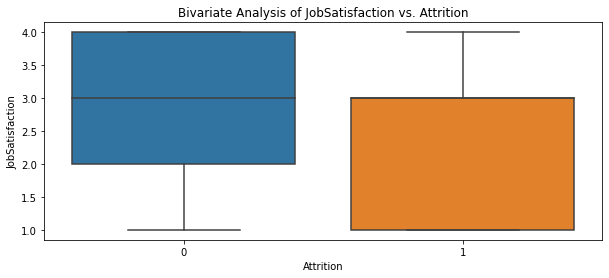

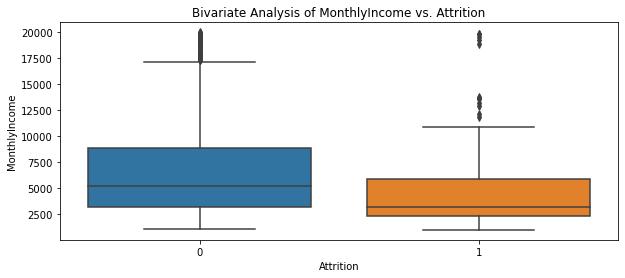

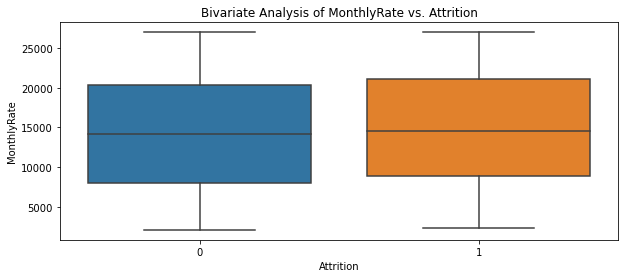

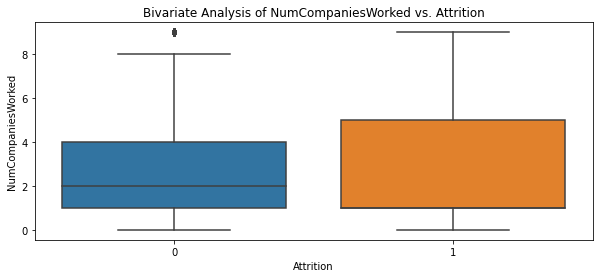

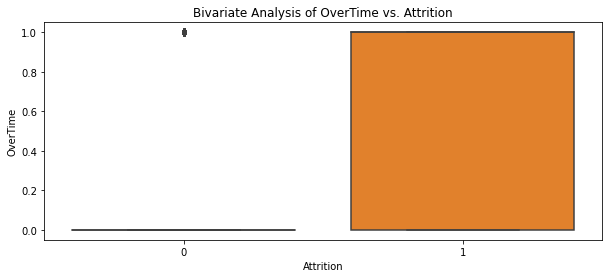

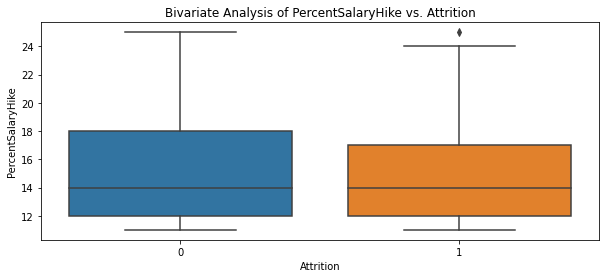

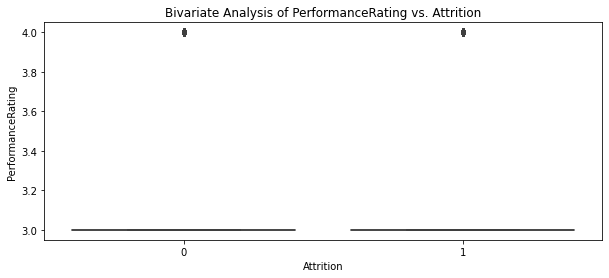

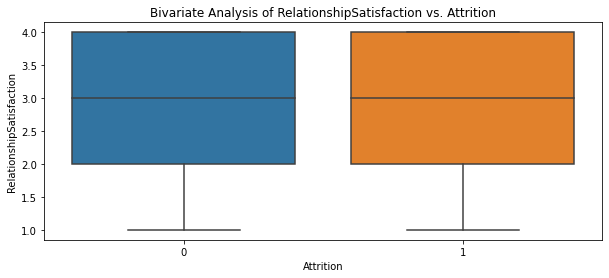

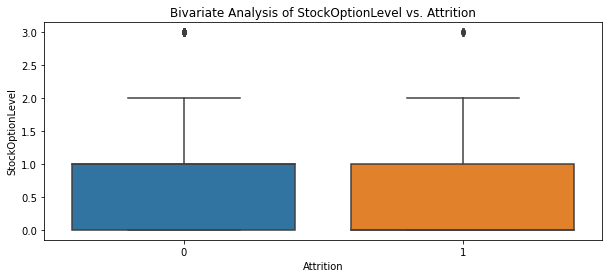

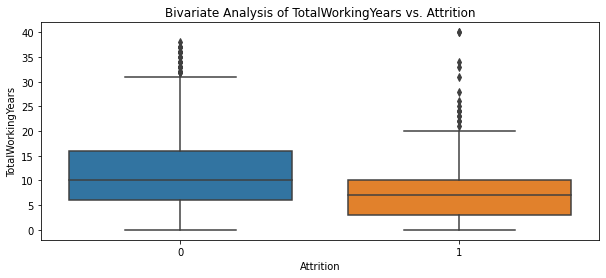

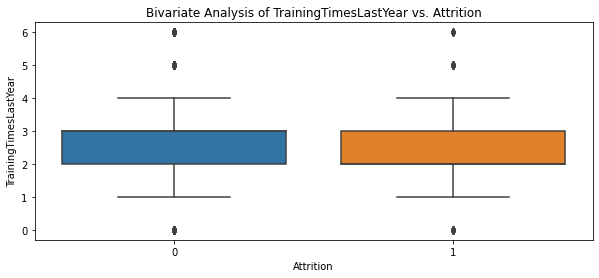

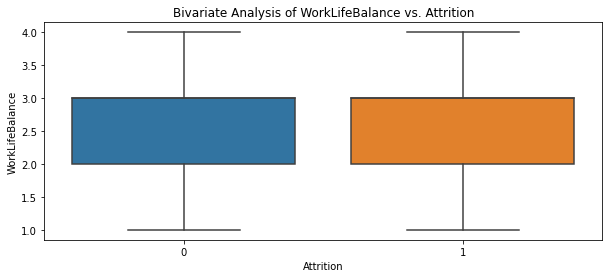

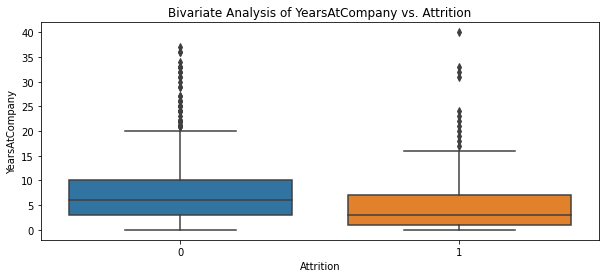

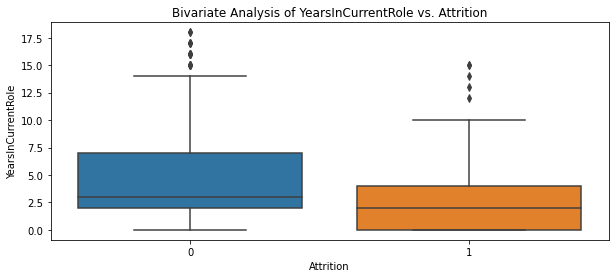

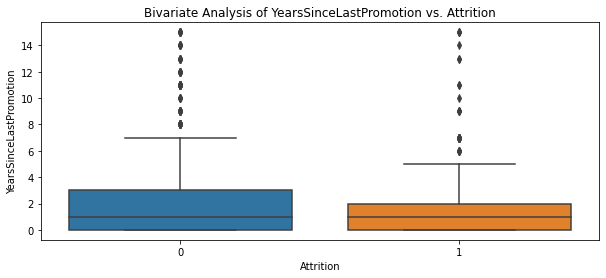

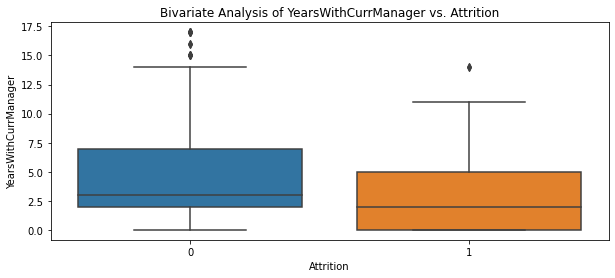

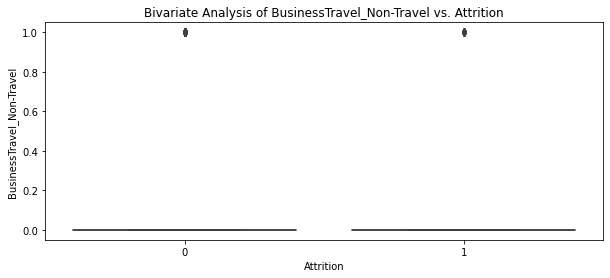

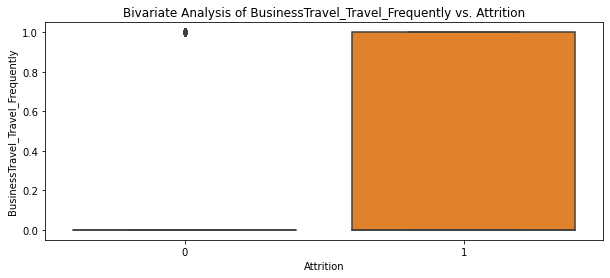

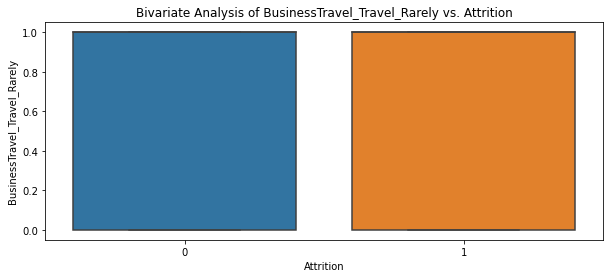

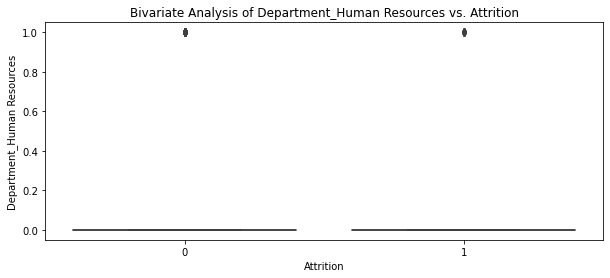

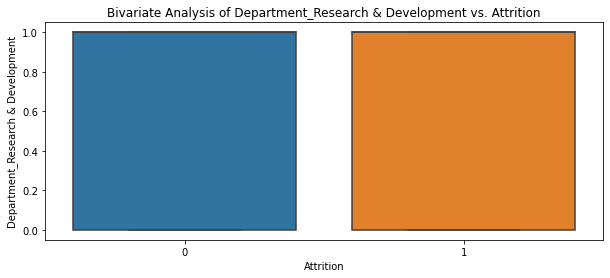

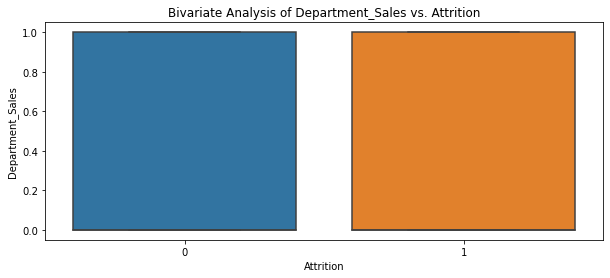

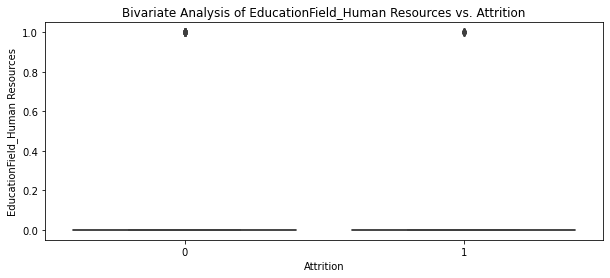

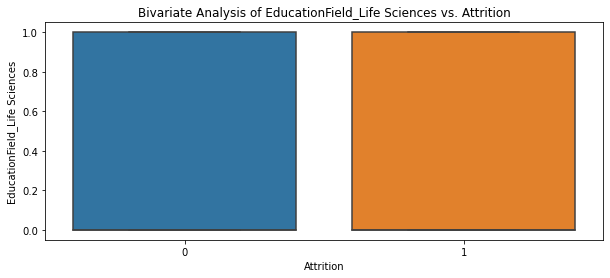

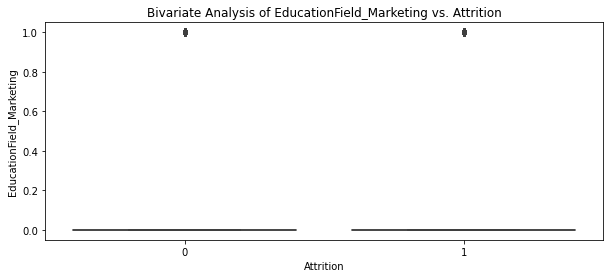

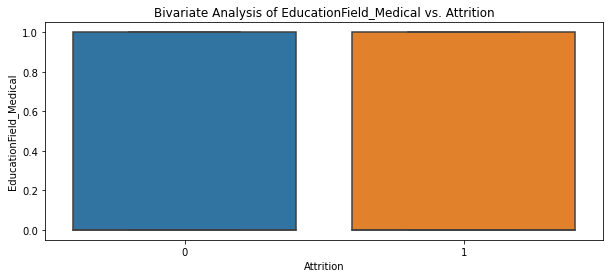

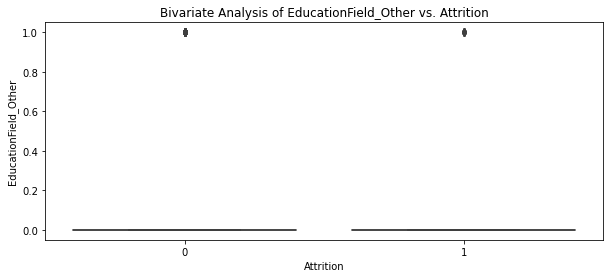

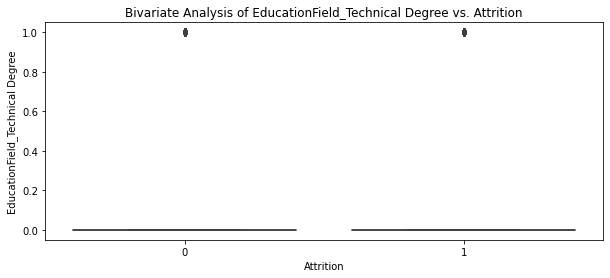

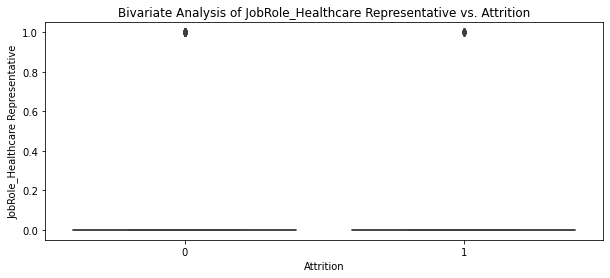

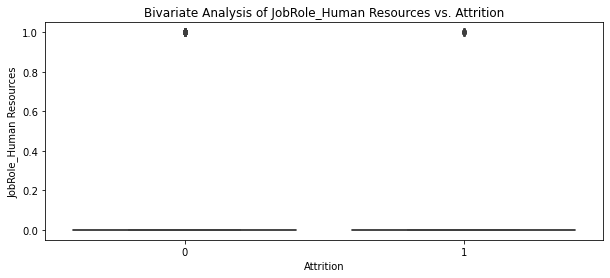

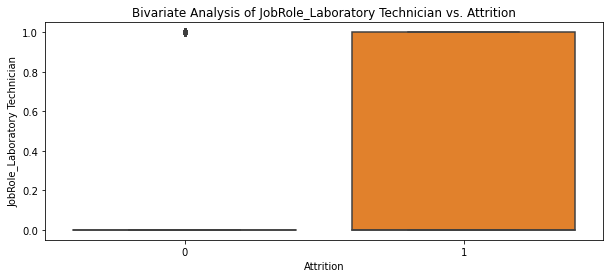

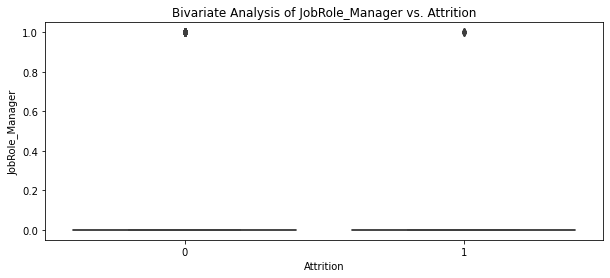

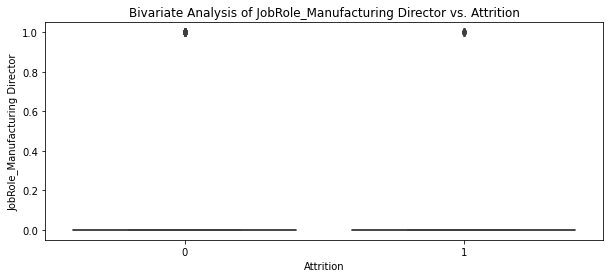

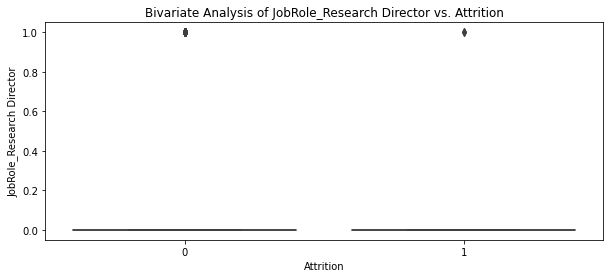

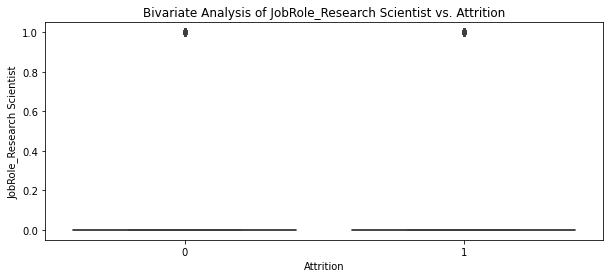

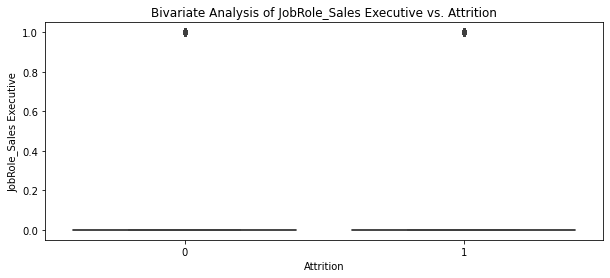

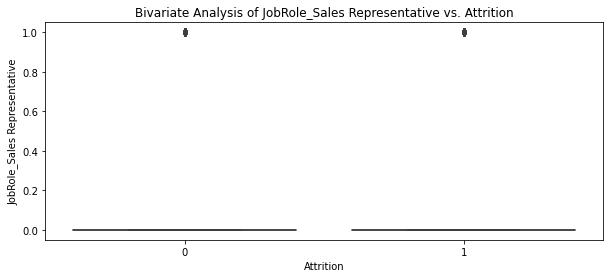

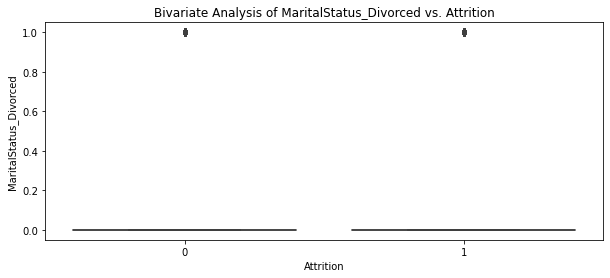

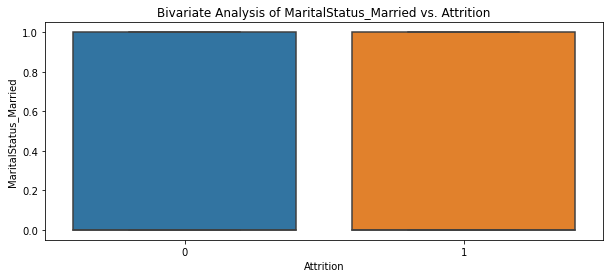

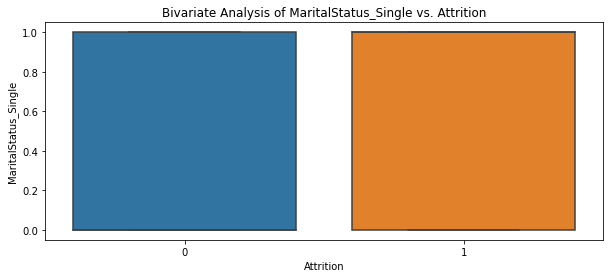

In [16]:
# Define a list of all features (exclude 'Attrition' as target variable)
all_features = df.columns.tolist()
all_features.remove('Attrition')

# Create subplots for visualizing bivariate relationships for all features
for feature in all_features:
    if df[feature].dtype == 'object':
        # For categorical features, use count plots
        plt.figure(figsize=(10, 4))
        sns.countplot(x=feature, hue='Attrition', data=df)
        plt.title(f"Bivariate Analysis of {feature} vs. Attrition")
    else:
        # For numerical features, use box plots
        plt.figure(figsize=(10, 4))
        sns.boxplot(x='Attrition', y=feature, data=df)
        plt.title(f"Bivariate Analysis of {feature} vs. Attrition")
    plt.show()

### 3.6: Correlation analysis
I want to understand which variables correlate most with attrition and I also want to see if some of the variables correlate with eachother to potentially drop some. 

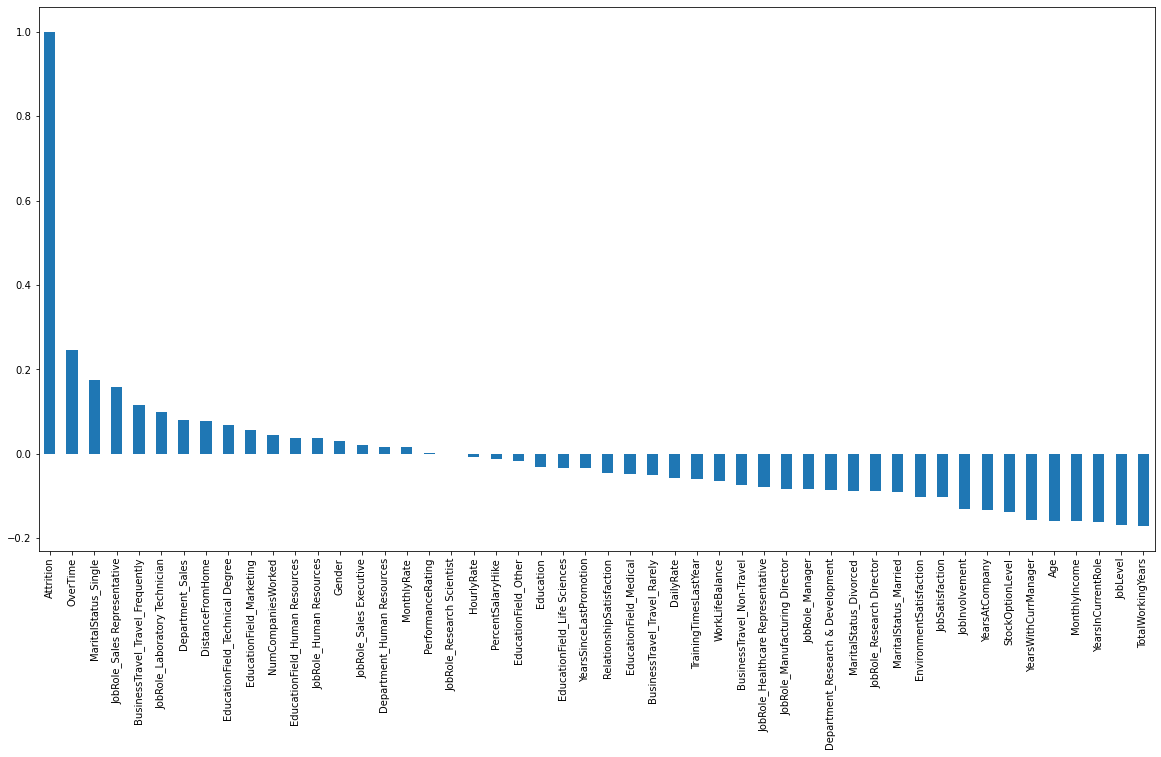

In [17]:
#correlation matrix
plt.figure(figsize=(20,10))
correlations=df.corr()
correlations['Attrition'].sort_values(ascending = False).plot(kind='bar');

In [18]:
#show the actual correlation values
print(correlations["Attrition"].sort_values(ascending=False))

Attrition                            1.000000
OverTime                             0.246118
MaritalStatus_Single                 0.175419
JobRole_Sales Representative         0.157234
BusinessTravel_Travel_Frequently     0.115143
JobRole_Laboratory Technician        0.098290
Department_Sales                     0.080855
DistanceFromHome                     0.077924
EducationField_Technical Degree      0.069355
EducationField_Marketing             0.055781
NumCompaniesWorked                   0.043494
EducationField_Human Resources       0.036466
JobRole_Human Resources              0.036215
Gender                               0.029453
JobRole_Sales Executive              0.019774
Department_Human Resources           0.016832
MonthlyRate                          0.015170
PerformanceRating                    0.002889
JobRole_Research Scientist          -0.000360
HourlyRate                          -0.006846
PercentSalaryHike                   -0.013478
EducationField_Other              

### Interpretation
The correlation graph shows some interesting but at the same time logical findings.
Here are the highest positive correlations with Attrition:
- Overtime (.25)
- Marital Status = Single (.18)
- Job Role = Sales Rep (.16)
- Business Travel = Frequently (.12)
- Job Role = Lab Technician (.1)

People who are single, work overtime, travel frequently and belong to the job roles Sales Rep or Lab Technicians seem to have a higher attrition than others.

Here are the highest negative correlations with Attrition:
- Total Working Years (-.17)
- Job Level (-.17)
- Years in Current Role (-.16)
- Monthly Income (-.16)
- Age (-.16)

The longer people work and the older they are, the higher their job level and monthly income is seem to quit less frequently than others. I assume that total working years, years in current role and age are correlated, so I might drop some of these.

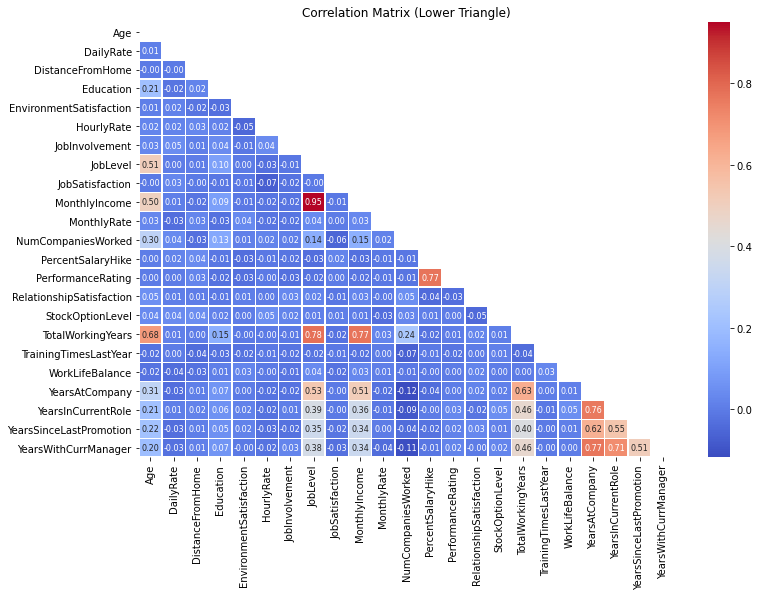

In [19]:
# Calculate the correlation matrix
correlation_matrix = df.select_dtypes(include=['int64']).corr()

# Create a mask to display only the lower triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the figure
plt.figure(figsize=(12, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, linewidths=0.5, annot_kws={"size": 8})

# Set the title
plt.title('Correlation Matrix (Lower Triangle)')

# Show the plot
plt.show()


### Interpretation
Job level and monthly income have such a high correlation that they are basically the same. 
Job level also has a high correlation with total working years, years at company, years in current role, time since last promotion and years with current manager.
I will drop the job level.

I will also drop total working years, years with current manager and years in current role. 

Finally, I will drop the performance rating, since it has a high correlation with the increase of salary. It also did not have a high correlation with attrition.

In [20]:
#dropping mentioned columns
df = df.drop(["JobLevel", "TotalWorkingYears", "YearsWithCurrManager",
              "YearsInCurrentRole", "YearsAtCompany","PerformanceRating"], axis=1)


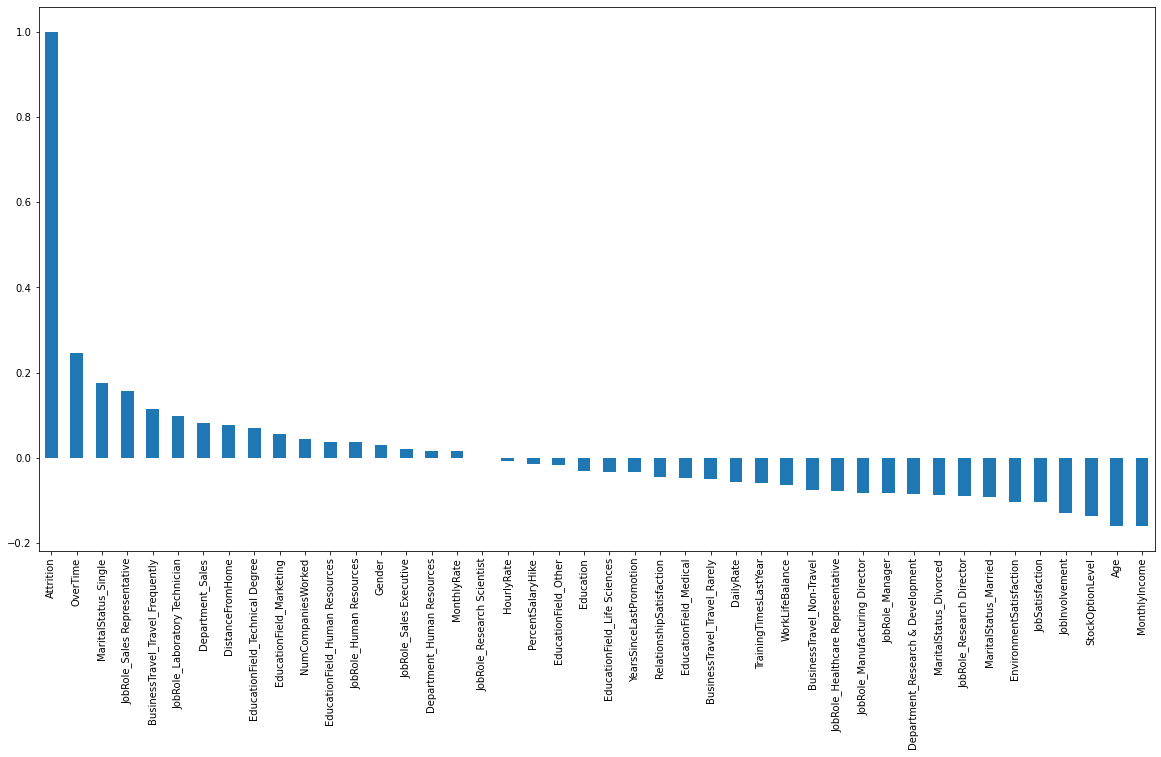

In [21]:
#correlation matrix
plt.figure(figsize=(20,10))
correlations=df.corr()
correlations['Attrition'].sort_values(ascending = False).plot(kind='bar');

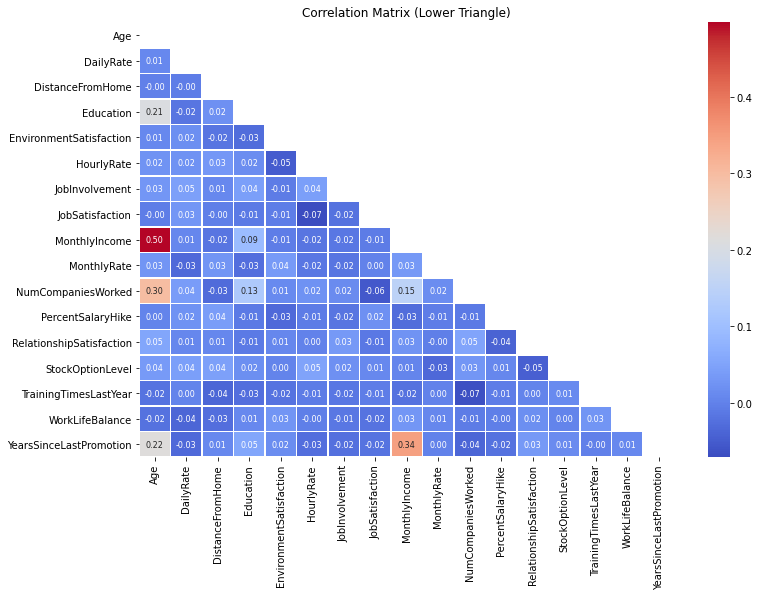

In [22]:
# Calculate the correlation matrix
correlation_matrix = df.select_dtypes(include=['int64']).corr()

# Create a mask to display only the lower triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the figure
plt.figure(figsize=(12, 8))

# Create a heatmap of the correlation matrix with a smaller font size
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, linewidths=0.5, annot_kws={"size": 8})

# Set the title
plt.title('Correlation Matrix (Lower Triangle)')

# Show the plot
plt.show()

## 4: Preparation steps for modeling
I will now:
- Split the data in my target variable and features 
- Do a train, test split to avoid data leakage
- Standardize the data
- Address class imbalance by applying SMOTE

In [23]:
# split data
y = df["Attrition"]
X = df.drop(["Attrition"], axis=1)

In [24]:
# perform train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [25]:
# Step 2: Standardize the training and test data based on training data statistics
standard_scaler = StandardScaler()
X_train_standardized = standard_scaler.fit_transform(X_train)
X_test_standardized = standard_scaler.transform(X_test)

In [26]:
# apply smote to handle the class imbalance
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_standardized, y_train)

## 5. Modeling
I will start with a baseline logistic regression model, then try other methods. 
For the model evaluation, I want to focus on __Recall__. 

__Precision__ = It tells us how many of the predicted positive cases are actually positive. <br>
__Recall__ = It is also called sensitivity which measures how many of the actual positive cases were correctly predicted as positive by the model.

I want to avoid that I miss any employees who have a risk to leave. Therefore, it is important that the model correctly identifies all the positive cases. 

### Model 1: Vanilla logistic regression model
Logistic Regression is often considered a baseline model for classification tasks due to its simplicity, interpretability, computational efficiency, and robustness. It models the relationship between features and the target class in a linear manner, making it a good choice when the underlying relationship is approximately linear. It serves as an essential starting point for building classification models and is used as a reference point to compare the performance of more complex models, helping to determine if the additional complexity is justified for a given problem. While Logistic Regression is valuable, its effectiveness may be limited in cases with highly nonlinear relationships or complex feature interactions, where more advanced models may be needed.

In [27]:
#initialize the logistic regression classifier
lr = LogisticRegression(random_state=42)
# fit classifier on training data
lr.fit(X_train_resampled, y_train_resampled)
#predict on test set
y_pred = lr.predict(X_test_standardized)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print model performance metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.75
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.76      0.84       255
           1       0.30      0.67      0.41        39

    accuracy                           0.75       294
   macro avg       0.62      0.71      0.63       294
weighted avg       0.85      0.75      0.78       294



The baseline logistic regression model has an accuracy of 0.75, indicating that it correctly predicts 75% of the cases. It achieves a higher precision for class 0 (non-attrition), suggesting that when it predicts an employee will not leave, it is often correct. However, its lower recall for class 1 (attrition) suggests that it misses a substantial portion of actual attrition cases, resulting in a lower F1-score for this class.

## Model 2: Random Forest
Random Forest is a strong choice for a follow up model in a classification task, especially when dealing with complex data, feature interactions, or class imbalances. Its ensemble nature and flexibility make it a reliable and versatile option to consider after trying a simpler model like Logistic Regression.

In [28]:
#initialize the Random Forest classifier
rfc = RandomForestClassifier(random_state=42)
# fit classifier on training data
rfc.fit(X_train_resampled, y_train_resampled)
#predict on test set
y_pred = rfc.predict(X_test_standardized)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print model performance metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.89
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94       255
           1       0.75      0.23      0.35        39

    accuracy                           0.89       294
   macro avg       0.82      0.61      0.65       294
weighted avg       0.87      0.89      0.86       294



The random forest model demonstrates a higher overall accuracy of 0.89, indicating that it correctly predicts a higher percentage of cases. It achieves an excellent precision for class 0 (non-attrition), suggesting that when it predicts an employee will not leave, it is usually correct. However, its low recall for class 1 (attrition) implies that it misses a substantial portion of actual attrition cases, resulting in a lower F1-score for this class. While the model is better overall, it still struggles to identify employees at risk of attrition.

## Model 3: Random Forest with lowered threshold (higher sensitivity)

In [29]:
# Initialize a Random Forest classifier
clf = RandomForestClassifier(random_state=42)

# Train the classifier on the training data
clf.fit(X_train_resampled, y_train_resampled)

# Make probability predictions on the test set
y_prob = clf.predict_proba(X_test_standardized)[:, 1]  # Probability of class '1'

# Adjust the threshold to prioritize recall (lowering the threshold)
custom_threshold = 0.3  
y_pred = (y_prob >= custom_threshold).astype(int)

# Evaluate the model with the adjusted threshold
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print model performance metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.74
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.77      0.84       255
           1       0.28      0.56      0.37        39

    accuracy                           0.74       294
   macro avg       0.60      0.67      0.60       294
weighted avg       0.83      0.74      0.78       294



Lowering the threshold for the random forest model leads to a trade-off. While recall for class 1 (attrition) increases, meaning the model is better at identifying potential attrition cases, precision for the same class decreases. As a result, the model correctly identifies more cases of attrition but also generates more false positives, leading to a decrease in F1-score. The overall accuracy is also lower at 0.74. This adjusted model prioritizes capturing attrition cases at the expense of precision.

## Model 4: XGBoost Classifier

In [30]:
# Initialize an XGBoost classifier
xgb = xgb.XGBClassifier(random_state=42)

# Train the classifier on the training data
xgb.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = xgb.predict(X_test_standardized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print model performance metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.88
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93       255
           1       0.57      0.31      0.40        39

    accuracy                           0.88       294
   macro avg       0.74      0.64      0.67       294
weighted avg       0.86      0.88      0.86       294



The XGBoost classifier achieves a good overall accuracy of 0.88, indicating it correctly predicts the majority of cases. However, it has a relatively low recall of 0.31 for class 1 (attrition), suggesting it might not capture all the potential attrition cases. The precision for class 1 is also relatively low at 0.57, indicating there are some false positives.

## Model 5: Logistic Regression with tuned hyperparameters
My baseline model was better than others when it comes to the recall scores of class 1. I'm trying to further improve it by trying some other parameters

In [31]:
# Define hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Different values of regularization strength
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'saga'],
}

# Initialize logistic regression classifier
lr = LogisticRegression(random_state=42)

# Create a grid search object
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='recall')

# Fit the grid search to the data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Use the best estimator to make predictions
y_pred = best_estimator.predict(X_test_standardized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the best hyperparameters and model performance
print("Best Hyperparameters:", best_params)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)

Best Hyperparameters: {'C': 0.001, 'solver': 'liblinear'}
Accuracy: 0.64
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.62      0.75       255
           1       0.23      0.72      0.34        39

    accuracy                           0.64       294
   macro avg       0.58      0.67      0.55       294
weighted avg       0.84      0.64      0.69       294



The hyperparameter-tuned logistic regression model, with the best parameters C=0.001 and solver='liblinear', exhibits a lower accuracy of 0.64 compared to the baseline models. It has a relatively high recall of 0.72 for class 1 (attrition), meaning it is better at identifying attrition cases, but at the cost of precision, which is low at 0.23. The F1-score for class 1 is also relatively low at 0.34.

## Model 6: Random Forest with tuned hyperparameters

In [32]:
# This cell can take a long time to run!
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [75,100],
    'min_samples_split': [ 8, 10],
    'max_depth': [5,15 ]
}

# Create a grid search object
grid_obj = GridSearchCV(
    rf_classifier,
    param_grid=param_grid,
    scoring='recall',
    cv=10
)

# Fit the grid search to the data
grid_fit = grid_obj.fit(X_train_resampled, y_train_resampled)

# Get the best estimator
rf_opt = grid_fit.best_estimator_

# Make probability predictions on the test set
y_prob = rf_opt.predict_proba(X_test_standardized)[:, 1]  # Probability of class '1'

# Adjust the threshold to prioritize recall (lowering the threshold)
custom_threshold = 0.25  
y_pred = (y_prob >= custom_threshold).astype(int)

# Evaluate the model with the adjusted threshold
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print best hyperparameters, model performance metrics, and adjusted threshold
print("Best Hyperparameters:", grid_fit.best_params_)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)

Best Hyperparameters: {'max_depth': 15, 'min_samples_split': 8, 'n_estimators': 100}
Accuracy: 0.72
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.72      0.82       255
           1       0.28      0.72      0.41        39

    accuracy                           0.72       294
   macro avg       0.61      0.72      0.61       294
weighted avg       0.86      0.72      0.76       294



The random forest model with hyperparameter tuning, where the best hyperparameters are max_depth=15, min_samples_split=8, and n_estimators=150, shows an accuracy of 0.72. It has a relatively higher recall of 0.72 for class 1 (attrition) compared to the untuned random forest model, indicating better performance in identifying attrition cases. However, the precision for class 1 is relatively low at 0.28, resulting in an F1-score of 0.41.

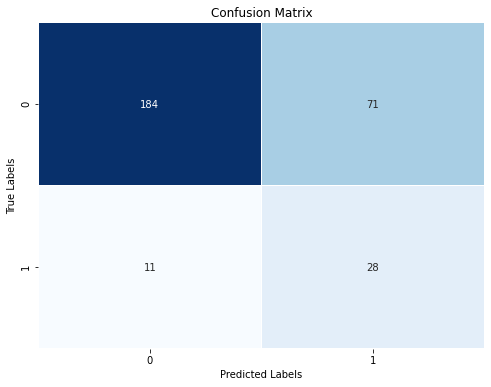

In [33]:
# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Create a Seaborn heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

plt.show()

## 6. Model evaluation

My final Random Forest model with the lowered threshold is showing a moderate accuracy of 72%. The model has significantly improved recall for class 1, with a recall score of 72%. This means that it correctly identifies 72% of the positive cases (class 1). However, this comes at the cost of precision, which is relatively low at 28%.
The confusion matrix shows the following:

- 184 employees were correctly classified as no attrition (True Negative)
- 28 employees were correctly classified as attrition (True Positive)
- 11 employees were falsely classified as no attrition (False Positive)
- 71 employees were falsely classified as attrition (False Negative)

This means that while it's performing quite good at identifying those who really want to leave, it also highlights some employees who actually do not want to leave.
In our case, we can accept it for now because our main goal is to retain our employees. This model will only act as an indicator and an actual human (HR business partner) will decide and talk to the employees if there is really a risk or not.

In order to know what to offer employees with a wish to leave, we need to understand the most important features of the model. This will show us what are the reasons for people wanting to leave and which we can change for some employees.

Feature Importances:
OverTime: 0.1440
MonthlyIncome: 0.0669
StockOptionLevel: 0.0615
JobSatisfaction: 0.0514
Age: 0.0424
MaritalStatus_Single: 0.0384
WorkLifeBalance: 0.0372
EnvironmentSatisfaction: 0.0358
JobInvolvement: 0.0351
HourlyRate: 0.0335
TrainingTimesLastYear: 0.0309
DailyRate: 0.0309
NumCompaniesWorked: 0.0306
DistanceFromHome: 0.0302
MonthlyRate: 0.0279
YearsSinceLastPromotion: 0.0272
RelationshipSatisfaction: 0.0272
Education: 0.0263
PercentSalaryHike: 0.0258
Gender: 0.0256
MaritalStatus_Married: 0.0201
BusinessTravel_Travel_Frequently: 0.0168
MaritalStatus_Divorced: 0.0130
JobRole_Laboratory Technician: 0.0126
JobRole_Healthcare Representative: 0.0093
EducationField_Medical: 0.0093
Department_Research & Development: 0.0080
JobRole_Sales Executive: 0.0079
Department_Sales: 0.0076
BusinessTravel_Travel_Rarely: 0.0075
JobRole_Manufacturing Director: 0.0071
EducationField_Life Sciences: 0.0070
JobRole_Research Scientist: 0.0065
EducationField_Technical Degree: 0.0063
JobRole_

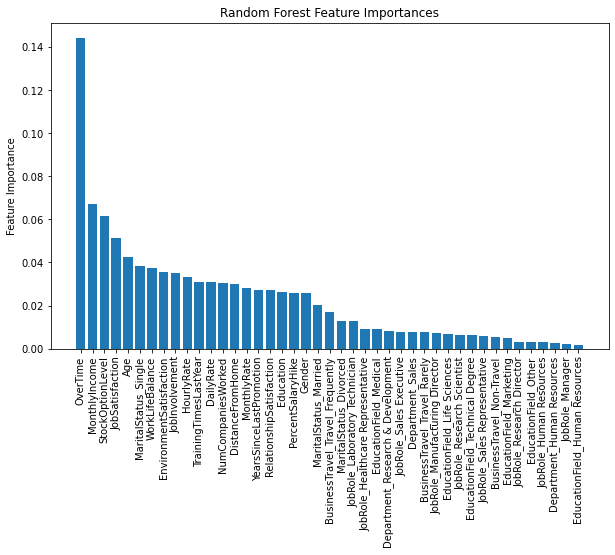

In [34]:
#calculating feature importance
feature_importances = clf.feature_importances_
feature_names = X_train.columns
importances, names = zip(*sorted(zip(feature_importances, feature_names), reverse=True))
#printing a list of importances
print("Feature Importances:")
for importance, name in zip(importances, names):
    print(f"{name}: {importance:.4f}")

#plotting importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(names)), importances, align="center")
plt.xticks(range(len(names)), names, rotation='vertical')
plt.ylabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.show()



### Interpretation
The top five factors in the model are:
- Overtime
- Stock Option Level
- Monthly Income
- Job Satisfaction
- Work Life Balance

We can see that **Overtime** is by far the most important factor and it has a **positive correlation** with attrition. This means that if people have to work overtime, they are more likely to leave. 

Next, we have the **stock option level** which is **negatively correlated** with attrition. If people don't have the option to buy stocks, they are more likely to resign. Offering stocks could be a good option to retain employees who are at risk of leaving.

An employee's **monthly income** is also **negatively correlated** with attrition - the more people earn, the less likely they are to leave. Think about offering employees a raise to prevent them from leaving.

The **job satisfaction** also has a **negative correlation** with attrition. Work with employee's team leaders to understand what the employees with low job satisfaction are missing and how the experience on the job can be improved.

Finally, **work life balance** is also **negatively correlation** with attrition. The poorer the work life balance, the more likely employees are willing to leave. This matches the most important factor of overtime. 

In [35]:
# recalculate the correlation
correlations = df.corr()
attrition_correlations = correlations['Attrition'].sort_values(ascending=False)
print(attrition_correlations)

Attrition                            1.000000
OverTime                             0.246118
MaritalStatus_Single                 0.175419
JobRole_Sales Representative         0.157234
BusinessTravel_Travel_Frequently     0.115143
JobRole_Laboratory Technician        0.098290
Department_Sales                     0.080855
DistanceFromHome                     0.077924
EducationField_Technical Degree      0.069355
EducationField_Marketing             0.055781
NumCompaniesWorked                   0.043494
EducationField_Human Resources       0.036466
JobRole_Human Resources              0.036215
Gender                               0.029453
JobRole_Sales Executive              0.019774
Department_Human Resources           0.016832
MonthlyRate                          0.015170
JobRole_Research Scientist          -0.000360
HourlyRate                          -0.006846
PercentSalaryHike                   -0.013478
EducationField_Other                -0.017898
Education                         

## 7. Conclusion and next steps
In times of a very difficult recruiting market where there are more vacancies than candidates, it is really important to retain your employees and focus on developing and reskilling them. 
Sometimes, it comes very unexpected when an employee resigns and it's especially painful when they are one of your top performers or if they resign after only a short time with the company. Therefore, we developed a classification model based on a fictive dataset from Kaggle that can help in flagging if an employee is likely to leave or not. 

The model focuses on correctly identifying those who really want to leave by accepting that it will classify some employees as potential leavers who don't really want to leave. It's recommended to have an HR employee or line managers evaluate the actual risk of leaving by talking to the employees. 

As next steps, the model would be deployed in the HR department after collecting more data on leavers. Since the model is dealing with high class imbalance, the more information we gather about leavers, the better the model will perform. 
When deployed, we receive a probability for each employee that indicates their likelihood on leaving the company. Based on this information, a process needs to be defined on how to use this information. 

In any case, we already know the most important factors (overtime, income, job satisfaction, work-life balance and stock options) so the company should review its policies on remote working opportunities, salary progression and other benefits.